In [1]:
from pathlib import Path
from collections import defaultdict

from IPython.display import Image

# Use this to read in a CCD image
from astropy.nddata import CCDData

# Use this to respresent the coordinates of the variable star
from astropy.coordinates import SkyCoord

# We will use table to read and write tables of data as CSV files (or as FITS)
from astropy.table import Table

# We will use this to get the APASS stars in the field of view of an image
from stellarphot.utils import find_apass_stars

import requests
import pandas as pd
import json

In [2]:
# Star chart parameters
var_star_name = 'V0533 Her'

# File for saving comparison star magnitudes in
apass_mags_comp_stars = 'apass-V0533-Her.csv'

# You chould not need to change these....
fov = 40
limiting_magnitude = 16

In [3]:
payload = {'format':'json',
           'star': var_star_name,
           'fov': fov,
           'maglimit': limiting_magnitude
          }

r = requests.get('https://app.aavso.org/vsp/api/chart', params = payload)

print(r.url)

aavso_response = r.json()

https://app.aavso.org/vsp/api/chart/?format=json&star=V0533+Her&fov=40&maglimit=16


## L:ook at the chart below and decide which star will be your "check star"

### Write down its label (the 2 or 3 digit number near the star)

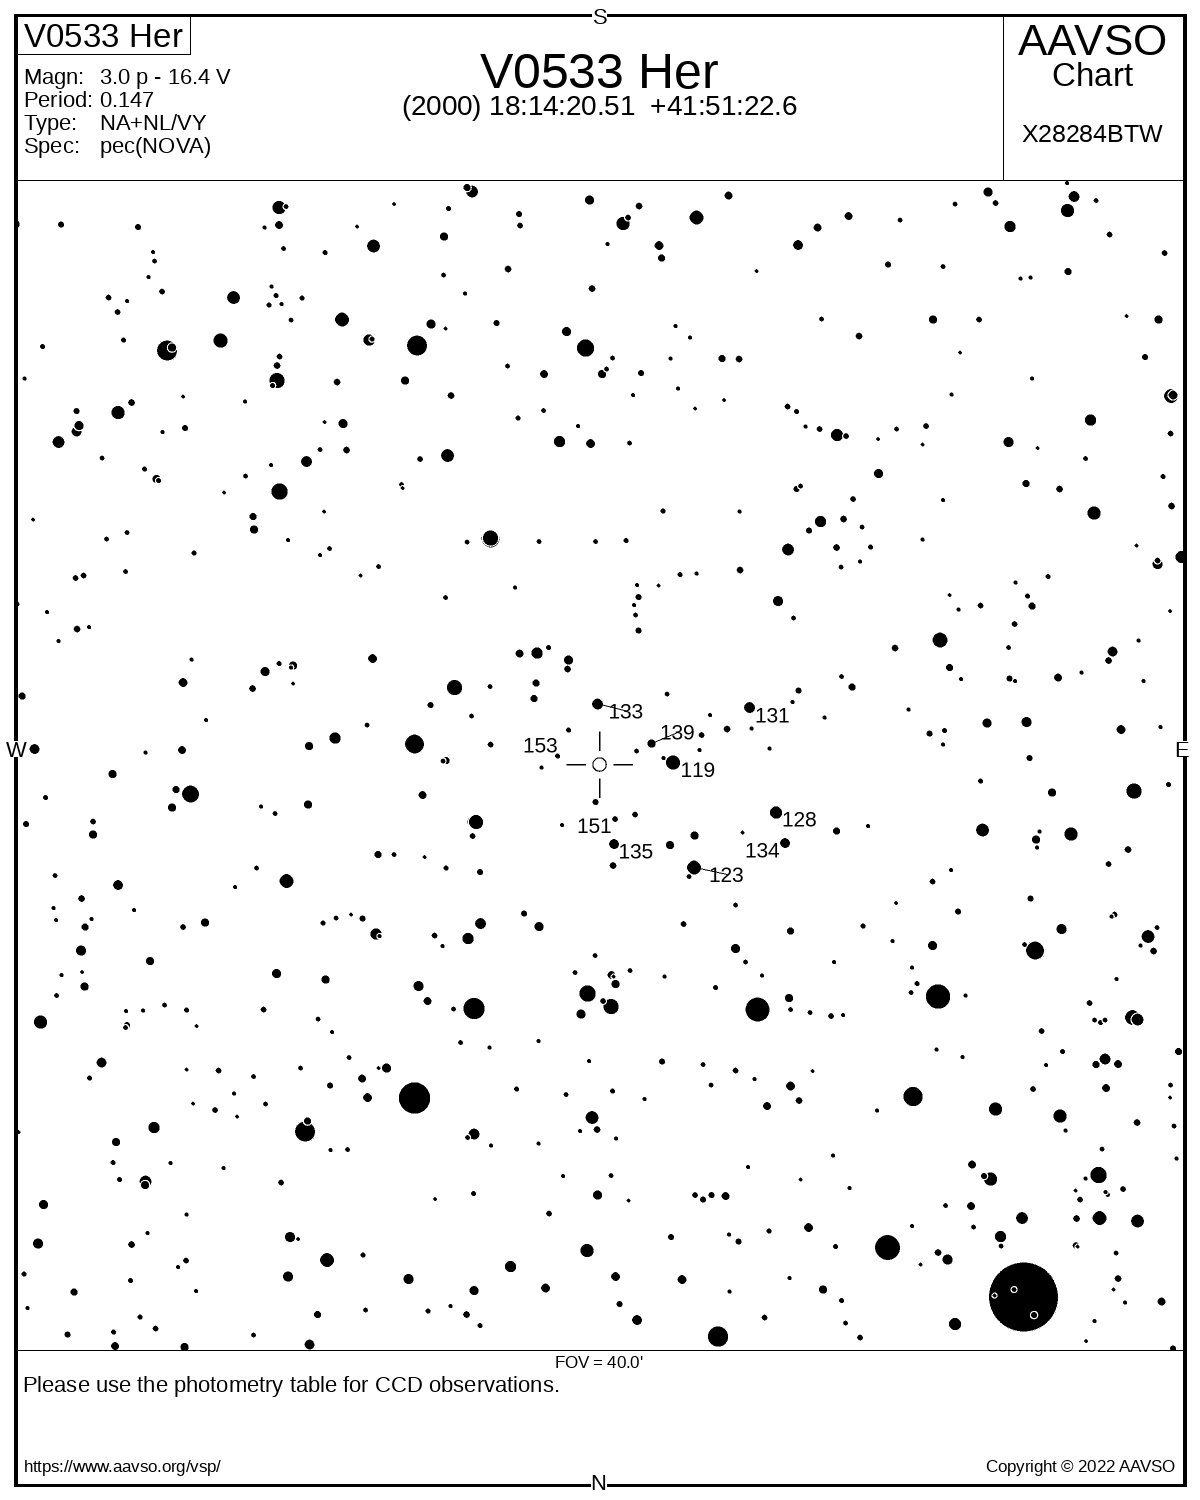

In [4]:
# Chop off the format argument at the end
image_uri = aavso_response['image_uri'].split("?")[0]
Image(image_uri)

In [5]:
var_coord = SkyCoord(ra=aavso_response['ra'], dec=aavso_response['dec'], unit=('hour', 'degree'))

In [6]:
if not aavso_response['photometry']:
    raise RuntimeError('No comparison stars for this variable -- request them from the AAVSO')


In [7]:
json = json.dumps(aavso_response['photometry'])
panda = pd.read_json(json, orient = 'records')

In [8]:
panda

,auid,ra,dec,label,bands,comments
0,000-BCS-520,18:14:34.02,41:51:18.5,119,"[{'band': 'V', 'mag': 11.935, 'error': 0.096},...",
1,000-BCS-524,18:14:37.93,41:54:53.9,123,"[{'band': 'V', 'mag': 12.256, 'error': 0.066},...",
2,000-BCS-531,18:14:52.94,41:53:00.3,128,"[{'band': 'V', 'mag': 12.756, 'error': 0.074},...",
3,000-BCS-529,18:14:48.07,41:49:26.0,131,"[{'band': 'V', 'mag': 13.09, 'error': 0.005}, ...",
4,000-BCS-512,18:14:20.20,41:49:18.3,133,"[{'band': 'V', 'mag': 13.273, 'error': 0.006},...",
5,000-BCS-532,18:14:54.61,41:54:03.3,134,"[{'band': 'V', 'mag': 13.437, 'error': 0.064},...",
6,000-BCS-514,18:14:23.19,41:54:06.0,135,"[{'band': 'V', 'mag': 13.491, 'error': 0.0}, {...",
7,000-BCS-517,18:14:30.10,41:50:39.5,139,"[{'band': 'V', 'mag': 13.939, 'error': 0.005},...",
8,000-BCS-515,18:14:23.35,41:53:14.3,151,"[{'band': 'V', 'mag': 15.078, 'error': 0.005},...",
9,000-BCS-510,18:14:12.81,41:51:05.1,153,"[{'band': 'V', 'mag': 15.32, 'error': 0.013000...",


In [9]:
aavso_comps = Table.from_pandas(panda)

In [10]:
aavso_comps['coords'] = SkyCoord(ra=aavso_comps['ra'], dec=aavso_comps['dec'], unit=('hour', 'degree'))

In [11]:
apass, apass_low_error = find_apass_stars(var_coord, max_mag_error=0.1, max_color_error=0.2)

apass['coords'] = SkyCoord(ra=apass['RAJ2000'], dec=apass['DEJ2000'], unit=('degree', 'degree'))



## Match the comp stars to APASS stars

One of the columns of the APASS table will be called `coords` and will be a list of coordinate objects. Astropy coordinates have the magical ability to match themselves to the coordinates of another set of coordinats.

You could use either the full apass list or the low error one below.

In [12]:
index, d2d, _ = aavso_comps['coords'].match_to_catalog_sky(apass['coords'])

In [13]:
if (d2d.arcsec > 1.5).any():
    raise RuntimeError('Coordinate mismatch')

In [14]:
apass_comp_stars = apass[index]

In [15]:
apass_comp_stars['auid'] = aavso_comps['auid']
apass_comp_stars['label'] = aavso_comps['label']

In [16]:
apass_mag_cols_band_map = dict(
    Vmag='V', Bmag='B', g_mag='SG', r_mag='SR', i_mag='SI'
)

mag_err_cols = {k: f'e_{k}' for k in apass_mag_cols_band_map.keys()}

In [17]:
del apass_comp_stars['coords'], apass_comp_stars['B-V'], apass_comp_stars['e_B-V']

In [18]:
constant_cols = set(apass_comp_stars.colnames) - set(apass_mag_cols_band_map.keys()) - set(mag_err_cols.values())

In [19]:
rearranged = defaultdict(list)
n_bands = len(apass_mag_cols_band_map.keys())

for row in apass_comp_stars:
    for cc in constant_cols:
        rearranged[cc].extend([row[cc]] * n_bands)
    for band, band_name in apass_mag_cols_band_map.items():
        rearranged['band'].append(band_name)
        rearranged['mag'].append(row[band])
        rearranged['mag_err'].append(row[mag_err_cols[band]])

In [20]:
rearranged = Table(rearranged)

In [21]:
rearranged

auid,recno,e_RAJ2000,Field,mobs,DEJ2000,e_DEJ2000,RAJ2000,label,nobs,band,mag,mag_err
str11,int32,float32,int64,int16,float64,float32,float64,int64,int16,str2,float32,float32
000-BCS-520,14537579,0.373,20121948,36,41.855157,0.246,273.641704,119,4,V,11.861,0.042
000-BCS-520,14537579,0.373,20121948,36,41.855157,0.246,273.641704,119,4,B,12.277,0.116
000-BCS-520,14537579,0.373,20121948,36,41.855157,0.246,273.641704,119,4,SG,12.039,0.053
000-BCS-520,14537579,0.373,20121948,36,41.855157,0.246,273.641704,119,4,SR,11.759,0.052
000-BCS-520,14537579,0.373,20121948,36,41.855157,0.246,273.641704,119,4,SI,11.677,0.055
000-BCS-524,14537585,0.469,20121948,36,41.914956,0.493,273.657989,123,4,V,12.174,0.066
000-BCS-524,14537585,0.469,20121948,36,41.914956,0.493,273.657989,123,4,B,13.28,0.114
000-BCS-524,14537585,0.469,20121948,36,41.914956,0.493,273.657989,123,4,SG,12.708,0.059
000-BCS-524,14537585,0.469,20121948,36,41.914956,0.493,273.657989,123,4,SR,11.81,0.045


In [22]:
rearranged.write(apass_mags_comp_stars, overwrite=True)

## Write AAVSO comparison magnitudes (from VSD)

Use similar logic to `rearranged` code above to get a flat table.